# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

Discente(s):
- Ana Sofia Lima (asosl)
- João Vitor Mergulhão (jvlm2)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefas

1. Multi-Layer Perceptron (MLP) para Regressão (50% da nota):
  - Implementação: Construa um MLP funcional para uma tarefa de regressão.
  - Experimentação:
      - Varie a arquitetura da rede (ex: número de camadas, neurônios por camada).
      - Teste diferentes otimizadores (ex: Adam, SGD).
      - Explore outras modificações que julgar pertinentes.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.
- Rede Neural Convolucional (CNN) (50% da nota):
  - Implementação: Proponha e construa sua própria arquitetura de CNN.
  - Implemente funções para o treinamento e avaliação do modelo.
  - Métricas e Análise:
    - Registre o tempo de treinamento de cada configuração.
    - Gere e apresente a matriz de confusão para os resultados da classificação.
    - Plote gráficos da função de loss e da acurácia ao longo das épocas de treinamento.
  - Experimentação:
    - Aplique e avalie técnicas de regularização (ex: Dropout, Batch Normalization).
    - Implemente e analise o Grad-CAM para visualização e interpretabilidade.
    - Explore outras técnicas relevantes para otimização ou análise de CNNs.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.

Dataset escolhido:

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd

import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tqdm import tqdm

from matplotlib import pyplot as plt

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

## Preprocessing


In [ ]:
# separação dos dados em features e target
X = student_performance.data.features.copy()

y = student_performance.data.targets["G3"].copy()

In [ ]:
# Label encoding para as features binárias
binary_map_cols = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "sex"]

for col in binary_map_cols:
  if col == "sex":
    X["sex"] = X[col].map({"F": 0, "M": 1}).astype("int64")
  else:
    X[col] = X[col].map({"no": 0, "yes": 1})

In [ ]:
# One-hot encoding para as features categóricas
categorical_cols = X.select_dtypes(include="object").columns.tolist()
print(categorical_cols)

['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']


In [ ]:
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = X.drop(categorical_cols, axis=1)

In [ ]:
numerical_cols = list(set(X.columns) - set(binary_map_cols) - set(categorical_cols))
print(numerical_cols)

['Fedu', 'freetime', 'health', 'failures', 'famrel', 'studytime', 'traveltime', 'Dalc', 'Medu', 'age', 'absences', 'Walc', 'goout']


In [ ]:
# Standard Scaling para as features numéricas
scaler = StandardScaler()
scaled_num = scaler.fit_transform(X[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_num, columns=numerical_cols, index=X.index)

In [ ]:
X_processed = pd.concat([one_hot_df, scaled_num_df, X[binary_map_cols]], axis=1)

In [ ]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   school_GP          649 non-null    float64
 1   school_MS          649 non-null    float64
 2   address_R          649 non-null    float64
 3   address_U          649 non-null    float64
 4   famsize_GT3        649 non-null    float64
 5   famsize_LE3        649 non-null    float64
 6   Pstatus_A          649 non-null    float64
 7   Pstatus_T          649 non-null    float64
 8   Mjob_at_home       649 non-null    float64
 9   Mjob_health        649 non-null    float64
 10  Mjob_other         649 non-null    float64
 11  Mjob_services      649 non-null    float64
 12  Mjob_teacher       649 non-null    float64
 13  Fjob_at_home       649 non-null    float64
 14  Fjob_health        649 non-null    float64
 15  Fjob_other         649 non-null    float64
 16  Fjob_services      649 non

In [ ]:
# separa treino e teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# separa treino e validação a partir do conjunto temporário
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 do total
)

In [ ]:
# Convertemos os DataFrames para tensores float32
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Datasets e Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
def evaluate(model, dataloader, criterion, device="cpu"):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)

## Train Loop

In [ ]:
# treinamento
# Early stopping setup
def trainModel(model, train_loader, val_loader, criterion, optimizer, n_epochs=50, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    val_losses = []
    best_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    model.to(device)

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        tqdm.write(f"Epoch {epoch+1} training loss: {epoch_loss:.4f}")

        # Avaliação
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        tqdm.write(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write("Early stopping triggered.")
                break

    # Carregar melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), "melhor_modelo.pth")

    return train_losses, val_losses

## Experiment 1

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model1()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  7%|▋         | 2/30 [00:00<00:01, 16.93it/s]

Epoch 1 training loss: 122.5673
Epoch 1 validation loss: 82.1855
Epoch 2 training loss: 43.9882
Epoch 2 validation loss: 8.5047
Epoch 3 training loss: 14.8751
Epoch 3 validation loss: 8.6261
Epoch 4 training loss: 9.6481
Epoch 4 validation loss: 7.9970


 23%|██▎       | 7/30 [00:00<00:01, 19.33it/s]

Epoch 5 training loss: 9.1432
Epoch 5 validation loss: 7.0090
Epoch 6 training loss: 8.5769
Epoch 6 validation loss: 6.8306
Epoch 7 training loss: 8.0701
Epoch 7 validation loss: 6.9203
Epoch 8 training loss: 7.8206
Epoch 8 validation loss: 6.9115


 37%|███▋      | 11/30 [00:00<00:01, 18.57it/s]

Epoch 9 training loss: 7.8473
Epoch 9 validation loss: 6.9263
Epoch 10 training loss: 7.6424
Epoch 10 validation loss: 6.7945
Epoch 11 training loss: 7.5121
Epoch 11 validation loss: 6.7518
Epoch 12 training loss: 7.3796
Epoch 12 validation loss: 6.5320


 50%|█████     | 15/30 [00:00<00:00, 17.30it/s]

Epoch 13 training loss: 7.2878
Epoch 13 validation loss: 6.5217
Epoch 14 training loss: 7.2606
Epoch 14 validation loss: 6.4983
Epoch 15 training loss: 7.1808
Epoch 15 validation loss: 6.5363
Epoch 16 training loss: 7.2204
Epoch 16 validation loss: 6.4203


 63%|██████▎   | 19/30 [00:01<00:00, 16.58it/s]

Epoch 17 training loss: 7.1514
Epoch 17 validation loss: 6.3234
Epoch 18 training loss: 7.1059
Epoch 18 validation loss: 6.3796
Epoch 19 training loss: 7.0279
Epoch 19 validation loss: 6.3745
Epoch 20 training loss: 7.1148
Epoch 20 validation loss: 6.5216


 70%|███████   | 21/30 [00:01<00:00, 16.68it/s]

Epoch 21 training loss: 7.1898
Epoch 21 validation loss: 6.5869
Epoch 22 training loss: 7.1341
Epoch 22 validation loss: 6.3903
Early stopping triggered.


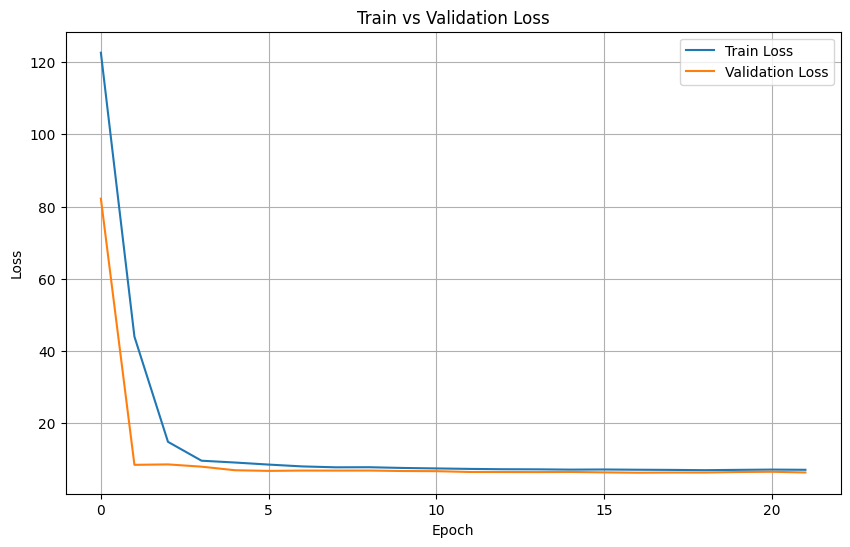

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.2006
RMSE: 2.9249
R²:   0.1227


In [ ]:
index = 51
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

NameError: name 'X_test_tensor' is not defined

In [ ]:
with torch.no_grad():
    y_pred = model(student).numpy()
y_pred

array([10.933074], dtype=float32)